In [1]:
# check how many events and what type of events are lost from sim to trigger to L1 to L2
import icecube
from icecube import icetray, dataio
from I3Tray import I3Tray
import glob
import os
from datetime import datetime
import json
import csv
import matplotlib.pyplot as plt
from icecube import MuonGun
import numpy as np

In [2]:
class counter_class(icetray.I3Module):
    def __init__(self, ctx):
        icetray.I3Module.__init__(self,ctx)
        self.nframes = 0
        self.current_n_physics = 0
        self.P_per_DAQ_dict = {}
        self.AddParameter("frames_dict", "number of frames by type", None)

    def Configure(self):
        self.frames_dict = self.GetParameter("frames_dict")
        self.frames_dict["DAQ"] = 0
        self.frames_dict["Physics"] = 0

    def DAQ(self, frame):
        self.frames_dict["DAQ"] += 1
        self.check_P_per_Q()

    def check_P_per_Q(self):
        val = self.current_n_physics
        if val != 0:
            if val not in self.P_per_DAQ_dict:
                self.P_per_DAQ_dict[val] = 1
            else:
                self.P_per_DAQ_dict[val] += 1
        self.current_n_physics = 0 # reset

    def Physics(self, frame):
        self.frames_dict["Physics"] += 1
        self.current_n_physics += 1

    def Finish(self):
        self.check_P_per_Q()
        print("Total number of frames ", self.frames_dict)
        print("P frames per Q frame", self.P_per_DAQ_dict)

def count_frames_in_file(filename, is_list = False):
    tray = I3Tray()

    if is_list:
        tray.Add("I3Reader", filenamelist=filename)
    else:
        tray.Add("I3Reader", filename=filename)
    frames_dict = {}
    tray.Add(counter_class, frames_dict = frames_dict)
    tray.Execute()
    return frames_dict
        
class save_ID(icetray.I3Module):
    def __init__(self, ctx):
        icetray.I3Module.__init__(self,ctx)
        self.AddParameter("event_id_list", "list_of_ids", None)

    def Configure(self):
        self.event_id_list = self.GetParameter("event_id_list")
        
    def DAQ(self, frame):
        self.event_id_list.append( (frame["I3EventHeader"].run_id, frame["I3EventHeader"].event_id) )

class remove_with_ID(icetray.I3Module):
    def __init__(self, ctx):
        icetray.I3Module.__init__(self,ctx)
        self.AddParameter("event_id_list", "list_of_ids", None)

    def Configure(self):
        self.event_id_list = self.GetParameter("event_id_list")
        
    def DAQ(self, frame):
        current_tuple = (frame["I3EventHeader"].run_id, frame["I3EventHeader"].event_id)
        if current_tuple not in self.event_id_list:
            self.PushFrame(frame)
        
    def Physics(self, frame):
        current_tuple = (frame["I3EventHeader"].run_id, frame["I3EventHeader"].event_id)
        if current_tuple not in self.event_id_list:
            self.PushFrame(frame)
            
def analyze_trigger_to_L2(datapath, name): 
    # create new folder to store stuff
    #now = datetime.now()
    #date_time_str = now.strftime("%Y%m%d%H%M%S")
    new_folder = "analyze_"+datapath[27:-1]+"/" # 27 is number of characters to LLP-data folder in path
    os.mkdir(new_folder)

    # path to trigger
    path_list_trigger = list(glob.glob(datapath+"LLPSim*/*.gz"),)
    # path to L1
    pathL1 = datapath + "L1.i3.gz"
    # path to L2
    pathL2 = datapath + "L2.i3.gz"

    # count losses
    analysis_dictionary = {}
    analysis_dictionary["dataset"] = datapath
    print("At trigger level: ")
    analysis_dictionary["trigger"] = count_frames_in_file(path_list_trigger, type(path_list_trigger) == list)
    print("At level 1: ")
    analysis_dictionary["L1"] = count_frames_in_file(pathL1, type(pathL1) == list)
    print("At level 2: ")
    analysis_dictionary["L2"] = count_frames_in_file(pathL2, type(pathL2) == list)

    # which L2 events survived?
    event_id_list_L2 = []
    tray = I3Tray()
    tray.Add("I3Reader", filename=pathL2)
    tray.Add(save_ID, event_id_list = event_id_list_L2)
    tray.Execute()
    analysis_dictionary["runID_eventID_survivedL2"] = event_id_list_L2
    with open(new_folder+"trigger_to_L2_analysis.json", "w") as f:
        json.dump(analysis_dictionary, f)

    # which L1 did not survive?
    tray = I3Tray()
    tray.Add("I3Reader", filenamelist=path_list_trigger)
    tray.Add(remove_with_ID, event_id_list = event_id_list_L2) # pass previous list
    tray.Add("I3Writer", filename=new_folder+"trigger_didnt_survive_L2_"+name+".i3.gz")
    tray.Execute()

In [3]:
# dataset enum
for enum in range(1,6):
    # which dataset
    if enum == 1:
        datapath = "/data/user/axelpo/LLP-data/DarkLeptonicScalar.mass-130.eps-5e-6.nevents-5000_230919.196721189/"
        name     = "DLS"
        folder_path = "analyze_"+datapath[27:-1]+"/"
    elif enum == 2:
        datapath = "/data/user/axelpo/LLP-data/DarkLeptonicScalar.mass-130.eps-5e-6.nevents-5000_naturalrate_230919.196721196/"
        name     = "DLS_naturalrate"
        folder_path = "analyze_"+datapath[27:-1]+"/"
    elif enum == 3:
        datapath = "/data/user/axelpo/LLP-data/NO_LLP.DarkLeptonicScalar.mass-130.eps-5e-6.nevents-5000_230919.196721202/"
        name     = "NO_LLP"
        folder_path = "analyze_"+datapath[27:-1]+"/"
    elif enum == 4:
        datapath = "/data/user/axelpo/LLP-data/NO_LLP.DarkLeptonicScalar.mass-130.eps-5e-6.nevents-5000_naturalrate_230919.196721201/"
        name     = "NO_LLP_naturalrate"
        folder_path = "analyze_"+datapath[27:-1]+"/"
    elif enum == 5:
        datapath = "/data/user/axelpo/LLP-data/DarkLeptonicScalar.mass-130.eps-5e-6.nevents-5000_eitherdecayorprod_230921.196832696/"
        name     = "DLS_eitherdecayorprod"
        folder_path = "analyze_"+datapath[27:-1]+"/"
    
    #analyze_trigger_to_L2(datapath, name)

In [4]:
#Function to read the GCD file and make the extruded polygon which
#defines the edge of the in-ice array
def MakeSurface(gcdName, padding):
    file = dataio.I3File(gcdName, "r")
    frame = file.pop_frame()
    while not "I3Geometry" in frame:
        frame = file.pop_frame()
    geometry = frame["I3Geometry"]
    xyList = []
    zmax = -1e100
    zmin = 1e100
    step = int(len(geometry.omgeo.keys())/10)
    print("Loading the DOM locations from the GCD file")
    for i, key in enumerate(geometry.omgeo.keys()):
        if i % step == 0:
            print( "{0}/{1} = {2}%".format(i,len(geometry.omgeo.keys()), int(round(i/len(geometry.omgeo.keys())*100))))
            
        if key.om in [61, 62, 63, 64] and key.string <= 81: #Remove IT...
            continue

        pos = geometry.omgeo[key].position

        if pos.z > 1500:
            continue
            
        xyList.append(pos)
        i+=1
    
    return MuonGun.ExtrudedPolygon(xyList, padding) 

class HistogramLLPs(icetray.I3Module):

    def __init__(self,ctx):
        icetray.I3Module.__init__(self,ctx)
        self.AddParameter("survivedL2", "survivedL2", None)
        self.AddParameter("folder_path", "folder_path", None)
        self.gcdFile = self.AddParameter("GCDFile", "GCDFile", "")
        
    def Configure(self): 
        self.survivedL2 = self.GetParameter("survivedL2")
        self.folder_path = self.GetParameter("folder_path")
        
        self.items_to_save = {"gaplength"             : {"bins": 100, "bounds": [0, 500]},
                              "zenith"                : {"bins": 20,  "bounds": [0, 1.7]},
                              "prodz"                 : {"bins": 20,  "bounds": [-800, 800]},
                              "decayz"                : {"bins": 20,  "bounds": [-800, 800]},
                              "Edeposited"            : {"bins": 100, "bounds": [0, 1000]},
                              "totalInitialE"         : {"bins": 100, "bounds": [0, 20000]},
                              "totalMCPulseCharge"    : {"bins": 100, "bounds": [0,4000]},
                              "totalDOMHits"          : {"bins": 100, "bounds": [0,2500]},

                             }
        self.InitializeHistograms()
        
        # create surface for detector volume
        self.gcdFile = self.GetParameter("GCDFile")
        if self.gcdFile != "":
            self.surface = MakeSurface(self.gcdFile, 0)
        else:
            self.surface = MuonGun.Cylinder(1000,500) # approximate detector volume
                              
    def InitializeHistograms(self):
        for key, val in self.items_to_save.items():
            self.items_to_save[key]["histogramdictionary"] = {"trigger": [], "L2": []} # create lists to hold values
            if "bins" not in self.items_to_save[key]:
                self.items_to_save[key]["bins"] = 50
            if "bounds" not in self.items_to_save[key]:
                self.items_to_save[key]["bounds"] = [-10, 10]
        
    def DAQ(self, frame):
        # fill histogram
        
        self.SaveInfo(frame, frame["LLPInfo"]["length"], self.items_to_save["gaplength"]["histogramdictionary"])
        self.SaveInfo(frame, frame["LLPInfo"]["length"], self.items_to_save["gaplength"]["histogramdictionary"])
        self.SaveInfo(frame, frame["LLPInfo"]["prod_z"], self.items_to_save["prodz"]["histogramdictionary"])
        self.SaveInfo(frame, frame["LLPInfo"]["prod_z"]-frame["LLPInfo"]["length"]*np.cos(frame["LLPInfo"]["zenith"]), self.items_to_save["decayz"]["histogramdictionary"])
        self.SaveInfo(frame, frame["I3MCTree_preMuonProp"].get_head().dir.zenith, self.items_to_save["zenith"]["histogramdictionary"])
        self.SaveInfo(frame, self.ComputeDepositedEnergy(frame), self.items_to_save["Edeposited"]["histogramdictionary"])
        self.SaveInfo(frame, self.ComputeTotalEnergyAtBoundary(frame), self.items_to_save["totalInitialE"]["histogramdictionary"])
        self.SaveInfo(frame, self.ComputeTotalMCPulseCharge(frame), self.items_to_save["totalMCPulseCharge"]["histogramdictionary"])
        self.SaveInfo(frame, self.ComputeTotalDOMHits(frame), self.items_to_save["totalDOMHits"]["histogramdictionary"])
        
        self.PushFrame(frame)
        
    def ComputeDepositedEnergy(self, frame):
        edep = 0
        for track in MuonGun.Track.harvest(frame['I3MCTree'], frame['MMCTrackList']):
            # Find distance to entrance and exit from sampling volume
            intersections = self.surface.intersection(track.pos, track.dir)
            # Get the corresponding energies
            e0, e1 = track.get_energy(intersections.first), track.get_energy(intersections.second)
            # Accumulate
            edep +=  (e0-e1)
        return edep
    
    def ComputeTotalMCPulseCharge(self, frame):
        totalCharge = 0
        for key, item in frame["I3MCPulseSeriesMap"]:
            totalCharge += sum([pulse.charge for pulse in item])
        return totalCharge
    
    def ComputeTotalDOMHits(self, frame):
        totalHits = 0
        for key, item in frame["I3MCPulseSeriesMap"]:
            totalHits += 1
        return totalHits
    
    def ComputeTotalEnergyAtBoundary(self, frame):
        totalE = 0
        for p in frame["I3MCTree_preMuonProp"].children(frame["I3MCTree_preMuonProp"].get_head()):
            totalE += p.energy
        return totalE
        
    def SaveInfo(self, frame, frameitem, listdictionary):
        listdictionary["trigger"].append(frameitem)
        if [frame["I3EventHeader"].run_id, frame["I3EventHeader"].event_id] in self.survivedL2:
            listdictionary["L2"].append(frameitem)
        
    def Finish(self):
        # plot histograms
        for key, val in self.items_to_save.items():
            current_sub_dict = self.items_to_save[key]
            plt.figure()
            plt.hist(current_sub_dict["histogramdictionary"]["trigger"], bins = current_sub_dict["bins"], range = current_sub_dict["bounds"], alpha = 0.3, color = "blue", label = "trigger")
            plt.hist(current_sub_dict["histogramdictionary"]["L2"], bins = current_sub_dict["bins"], range = current_sub_dict["bounds"], alpha = 0.3, color = "red", label = "L2")
            plt.legend()
            plt.yscale("log")
            plt.title(key)
            plt.savefig(self.folder_path + key +"_histogram.png")
            

class HistogramLevel2(icetray.I3Module):

    def __init__(self,ctx):
        icetray.I3Module.__init__(self,ctx)
        self.gcdFile = self.AddParameter("GCDFile", "GCDFile", "")
        self.filter_dict = {}
        self.AddParameter("folder_path", "folder_path", None)
        
    def Configure(self): 
        self.folder_path = self.GetParameter("folder_path")
        self.items_to_save = {"gaplength"             : {"bins": 100, "bounds": [0, 500]},
                              "zenith"                : {"bins": 20,  "bounds": [0, 1.7]},
                              "Edeposited"            : {"bins": 100, "bounds": [0, 1000]},
                              "totalEnergyAtBoundary" : {"bins": 100, "bounds": [0, 20000]},
                              "totalMCPulseCharge"    : {"bins": 100, "bounds": [0,1000]},
                             }
        self.InitializeHistograms()
        
        
        # create surface for detector volume
        self.gcdFile = self.GetParameter("GCDFile")
        if self.gcdFile != "":
            self.surface = MakeSurface(self.gcdFile, 0)
        else:
            self.surface = MuonGun.Cylinder(1000,500) # approximate detector volume
                              
    def InitializeHistograms(self):
        for key, val in self.items_to_save.items():
            self.items_to_save[key]["histogramdictionary"] = {"trigger": [], "L2": []} # create lists to hold values
            if "bins" not in self.items_to_save[key]:
                self.items_to_save[key]["bins"] = 50
            if "bounds" not in self.items_to_save[key]:
                self.items_to_save[key]["bounds"] = [-10, 10]
        
    def Physics(self, frame):
        if frame["I3EventHeader"].sub_event_stream == "InIceSplit":
            filters = frame["FilterMask"]
            for key, item in filters.items():
                if key in self.filter_dict:
                    self.filter_dict[key] += item.condition_passed
                else:
                    self.filter_dict[key] = item.condition_passed
        
    def SaveInfo(self, frame, frameitem, listdictionary):
        listdictionary["trigger"].append(frameitem)
        if [frame["I3EventHeader"].run_id, frame["I3EventHeader"].event_id] in self.survivedL2:
            listdictionary["L2"].append(frameitem)
        
    def Finish(self):
        # plot histograms
        fig, ax = plt.subplots()
        plt.bar(*zip(*self.filter_dict.items()))
        plt.xticks(rotation=90, ha='right')
        ax.margins(y=0.2)
        plt.tight_layout()
        plt.savefig(self.folder_path + "barchart_filters.png", bbox_inches="tight")
                

Loading the DOM locations from the GCD file
0/5489 = 0%
548/5489 = 10%
1096/5489 = 20%
1644/5489 = 30%
2192/5489 = 40%
2740/5489 = 50%
3288/5489 = 60%
3836/5489 = 70%
4384/5489 = 80%
4932/5489 = 90%
5480/5489 = 100%


NOTICE (I3Tray): I3Tray finishing... (I3Tray.cxx:526 in void I3Tray::Execute(bool, unsigned int))


Loading the DOM locations from the GCD file
0/5489 = 0%
548/5489 = 10%
1096/5489 = 20%
1644/5489 = 30%
2192/5489 = 40%
2740/5489 = 50%
3288/5489 = 60%
3836/5489 = 70%
4384/5489 = 80%
4932/5489 = 90%
5480/5489 = 100%


NOTICE (I3Tray): I3Tray finishing... (I3Tray.cxx:526 in void I3Tray::Execute(bool, unsigned int))


Loading the DOM locations from the GCD file
0/5489 = 0%
548/5489 = 10%
1096/5489 = 20%
1644/5489 = 30%
2192/5489 = 40%
2740/5489 = 50%
3288/5489 = 60%
3836/5489 = 70%
4384/5489 = 80%
4932/5489 = 90%
5480/5489 = 100%


NOTICE (I3Tray): I3Tray finishing... (I3Tray.cxx:526 in void I3Tray::Execute(bool, unsigned int))


Loading the DOM locations from the GCD file
0/5489 = 0%
548/5489 = 10%
1096/5489 = 20%
1644/5489 = 30%
2192/5489 = 40%
2740/5489 = 50%
3288/5489 = 60%
3836/5489 = 70%
4384/5489 = 80%
4932/5489 = 90%
5480/5489 = 100%


NOTICE (I3Tray): I3Tray finishing... (I3Tray.cxx:526 in void I3Tray::Execute(bool, unsigned int))


Loading the DOM locations from the GCD file
0/5489 = 0%
548/5489 = 10%
1096/5489 = 20%
1644/5489 = 30%
2192/5489 = 40%
2740/5489 = 50%
3288/5489 = 60%
3836/5489 = 70%
4384/5489 = 80%
4932/5489 = 90%
5480/5489 = 100%


NOTICE (I3Tray): I3Tray finishing... (I3Tray.cxx:526 in void I3Tray::Execute(bool, unsigned int))
/tmp/ipykernel_42579/3795930311.py:127: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")
/tmp/ipykernel_42579/3795930311.py:123: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Loading the DOM locations from the GCD file
0/5489 = 0%
548/5489 = 10%
1096/5489 = 20%
1644/5489 = 30%
2192/5489 = 40%
2740/5489 = 50%
3288/5489 = 60%
3836/5489 = 70%
4384/5489 = 80%
4932/5489 = 90%
5480/5489 = 100%


NOTICE (I3Tray): I3Tray finishing... (I3Tray.cxx:526 in void I3Tray::Execute(bool, unsigned int))


Loading the DOM locations from the GCD file
0/5489 = 0%
548/5489 = 10%
1096/5489 = 20%
1644/5489 = 30%
2192/5489 = 40%
2740/5489 = 50%
3288/5489 = 60%
3836/5489 = 70%
4384/5489 = 80%
4932/5489 = 90%
5480/5489 = 100%


NOTICE (I3Tray): I3Tray finishing... (I3Tray.cxx:526 in void I3Tray::Execute(bool, unsigned int))
/tmp/ipykernel_42579/3795930311.py:127: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


Loading the DOM locations from the GCD file
0/5489 = 0%
548/5489 = 10%
1096/5489 = 20%
1644/5489 = 30%
2192/5489 = 40%
2740/5489 = 50%
3288/5489 = 60%
3836/5489 = 70%
4384/5489 = 80%
4932/5489 = 90%
5480/5489 = 100%


NOTICE (I3Tray): I3Tray finishing... (I3Tray.cxx:526 in void I3Tray::Execute(bool, unsigned int))


Loading the DOM locations from the GCD file
0/5489 = 0%
548/5489 = 10%
1096/5489 = 20%
1644/5489 = 30%
2192/5489 = 40%
2740/5489 = 50%
3288/5489 = 60%
3836/5489 = 70%
4384/5489 = 80%
4932/5489 = 90%
5480/5489 = 100%


NOTICE (I3Tray): I3Tray finishing... (I3Tray.cxx:526 in void I3Tray::Execute(bool, unsigned int))


Loading the DOM locations from the GCD file
0/5489 = 0%
548/5489 = 10%
1096/5489 = 20%
1644/5489 = 30%
2192/5489 = 40%
2740/5489 = 50%
3288/5489 = 60%
3836/5489 = 70%
4384/5489 = 80%
4932/5489 = 90%
5480/5489 = 100%


NOTICE (I3Tray): I3Tray finishing... (I3Tray.cxx:526 in void I3Tray::Execute(bool, unsigned int))


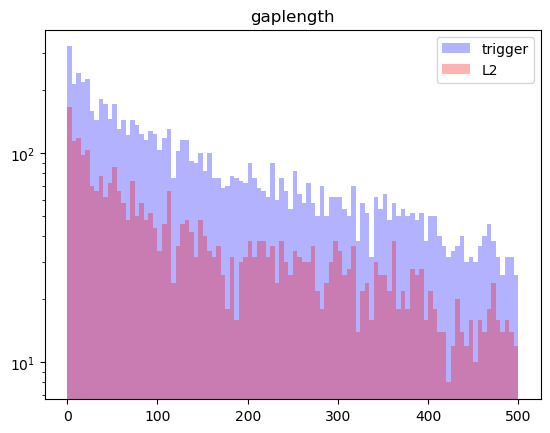

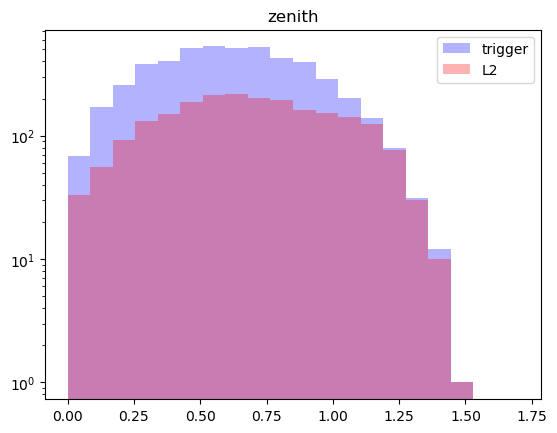

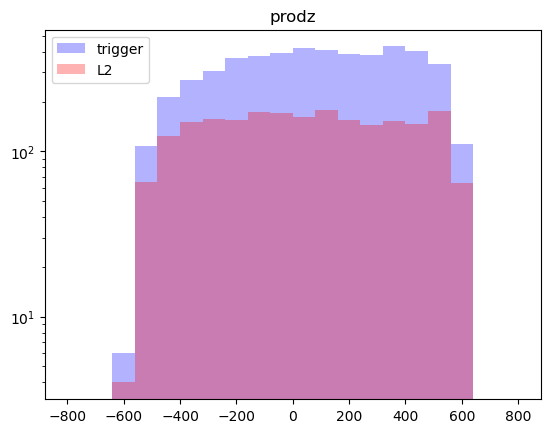

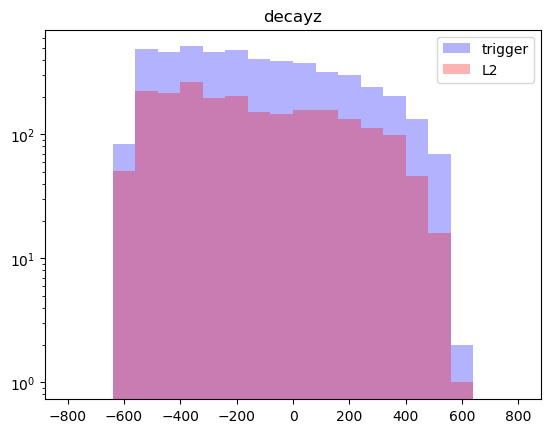

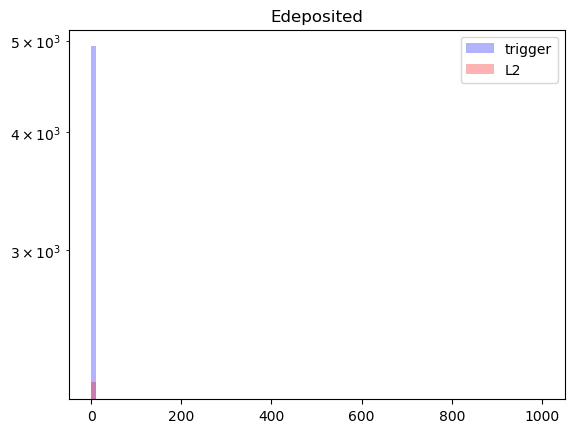

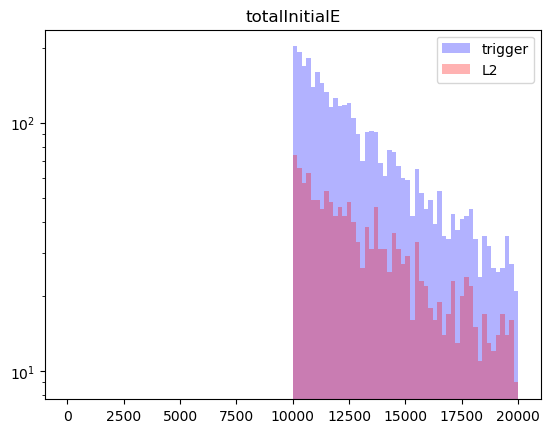

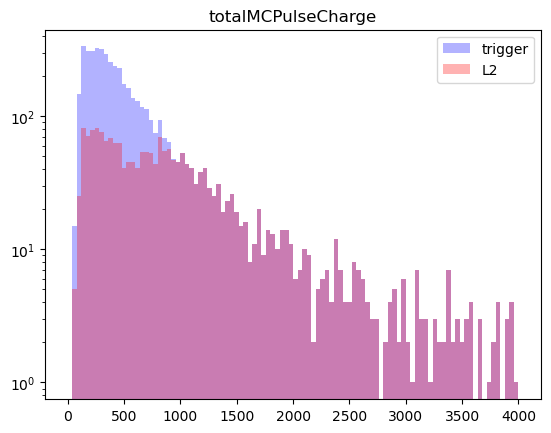

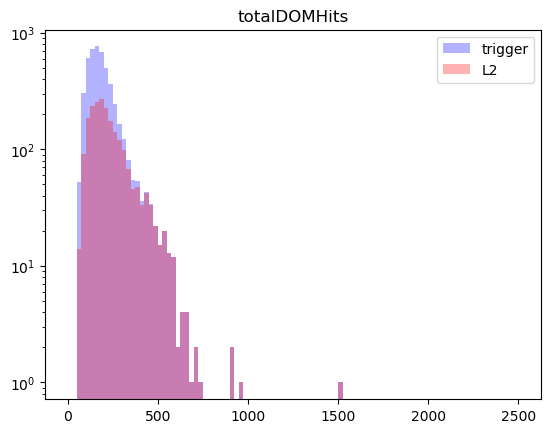

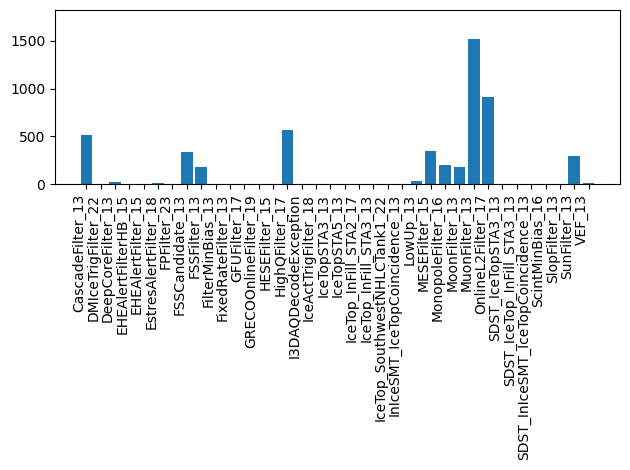

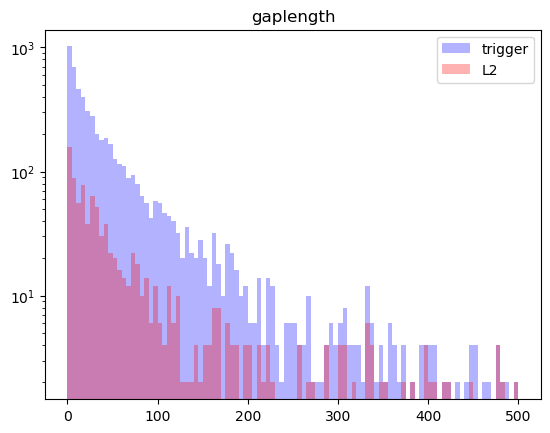

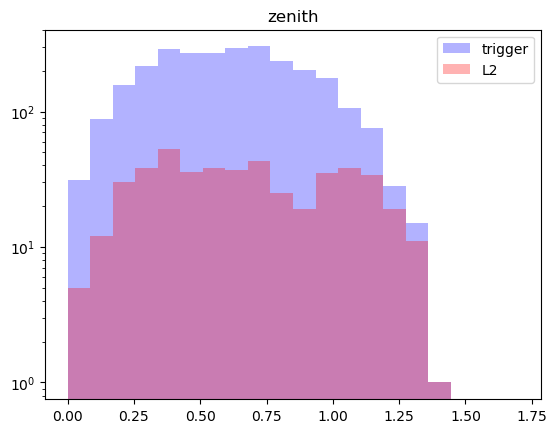

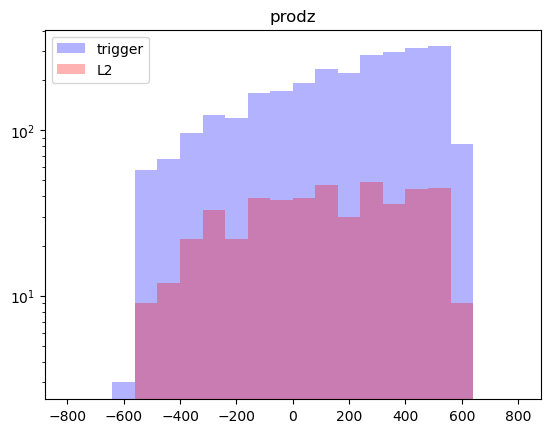

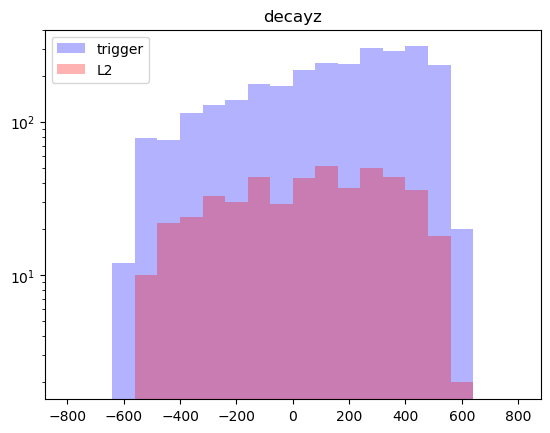

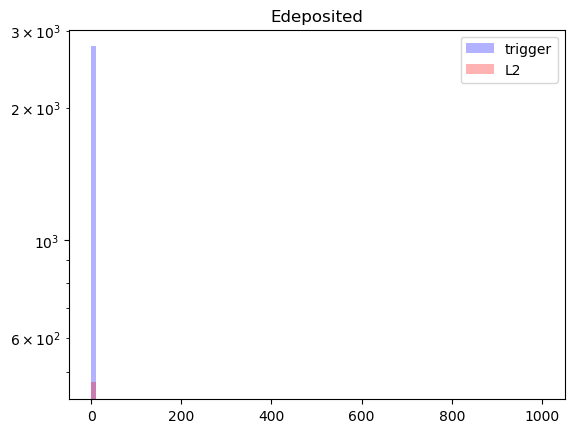

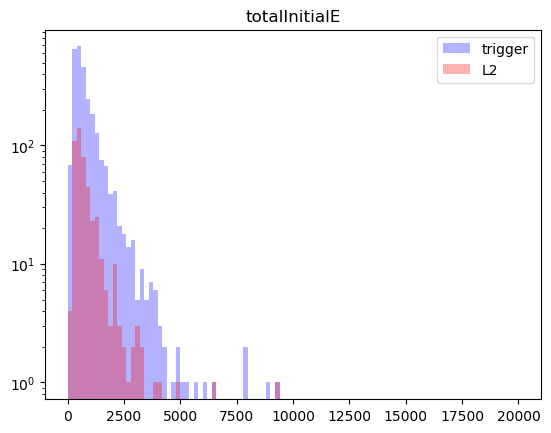

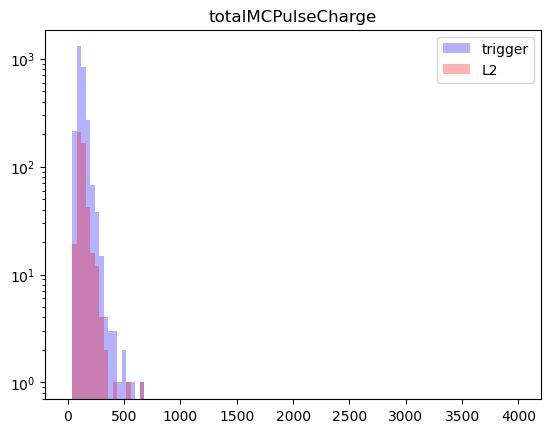

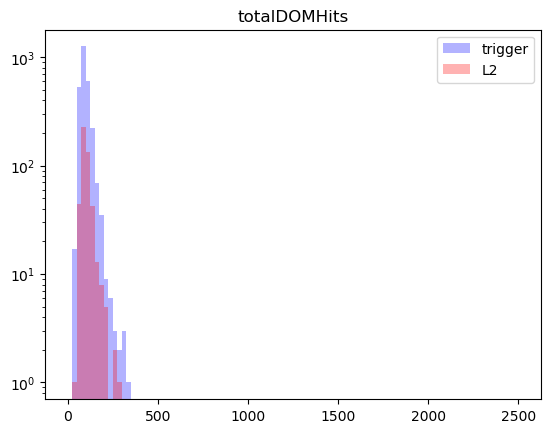

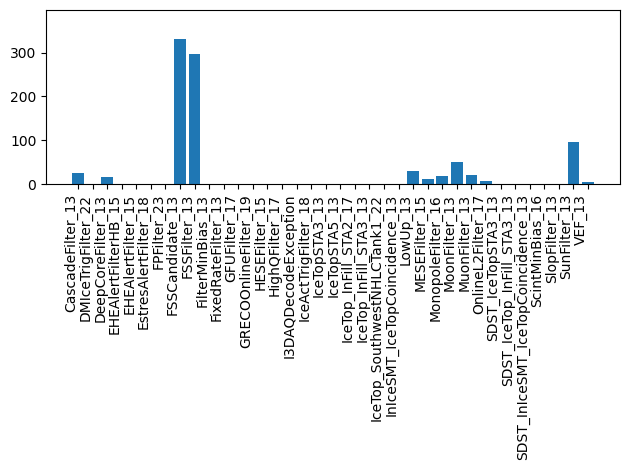

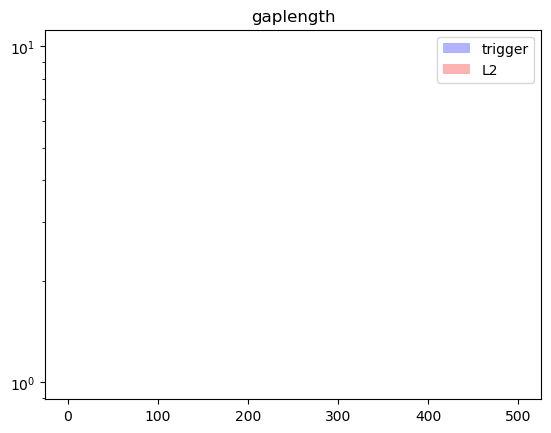

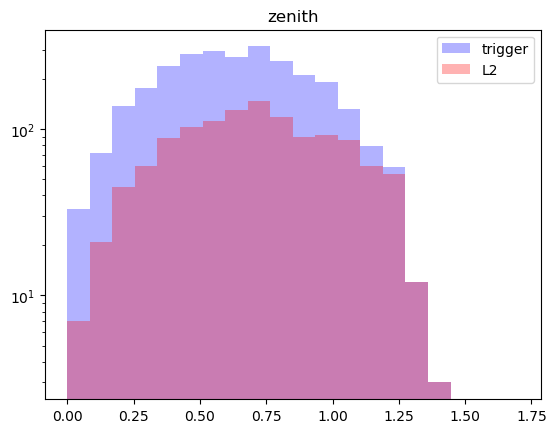

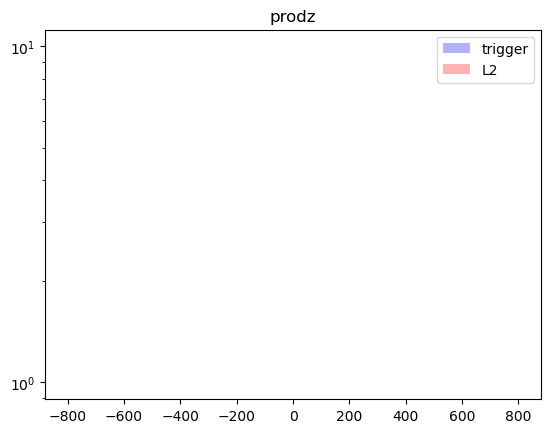

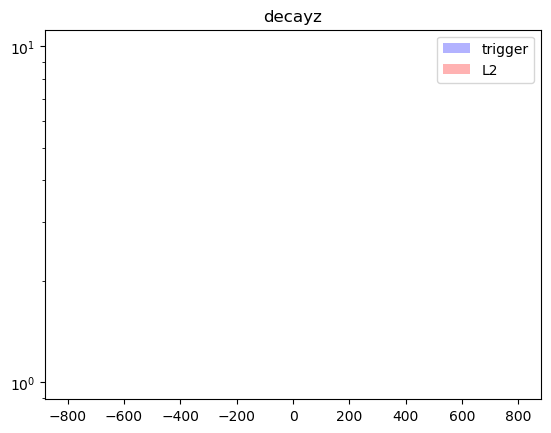

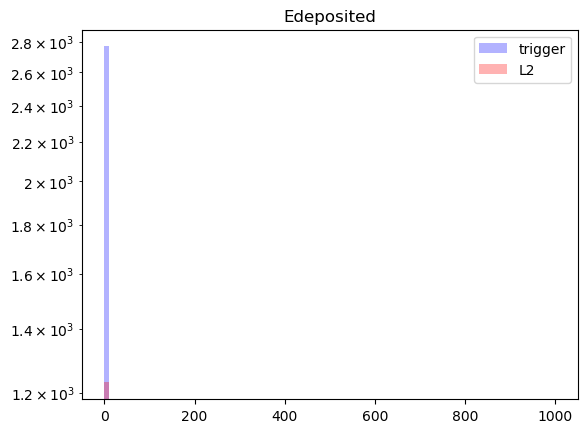

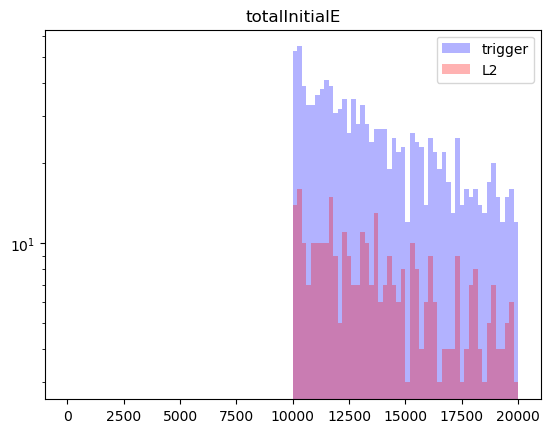

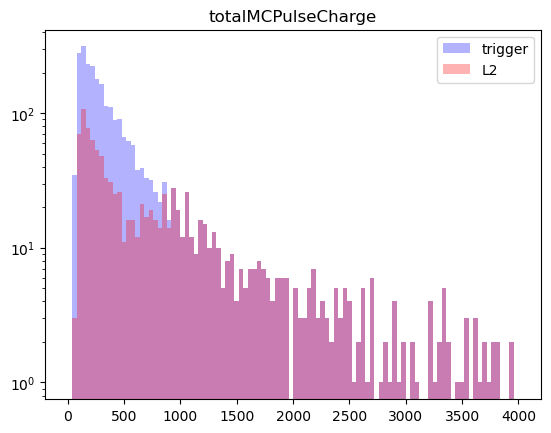

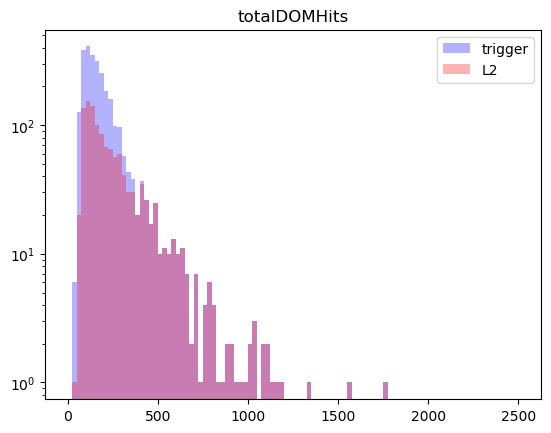

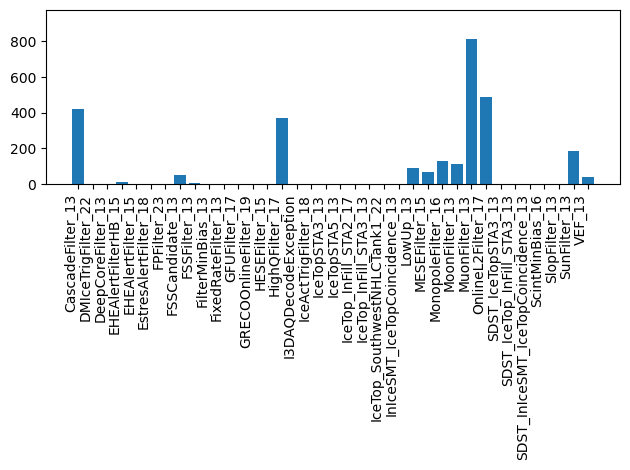

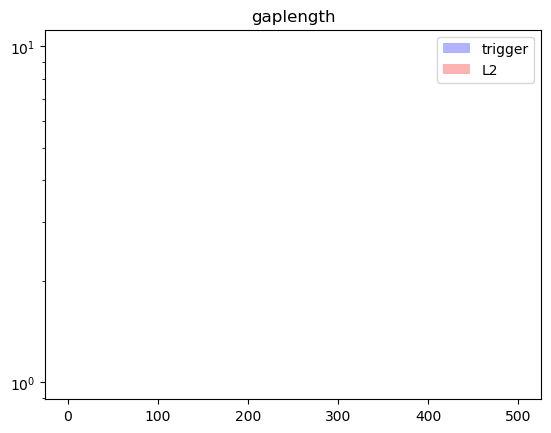

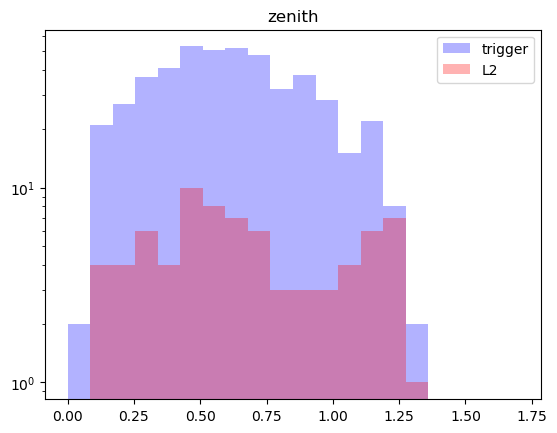

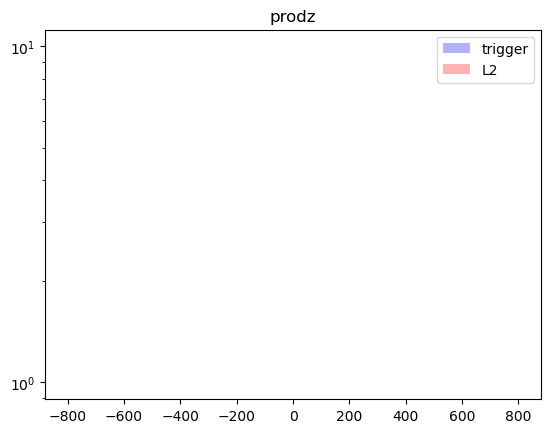

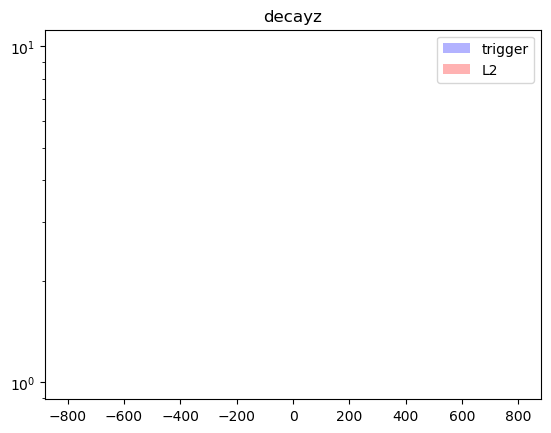

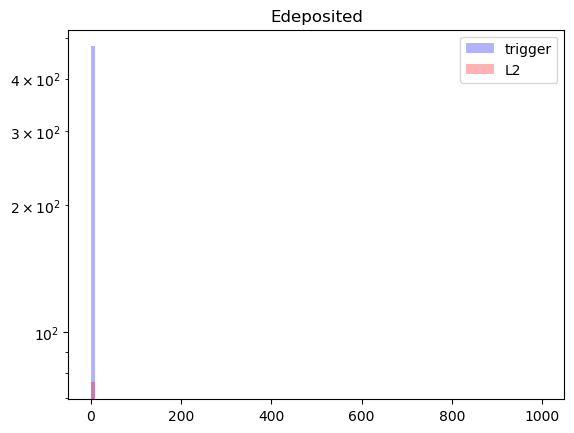

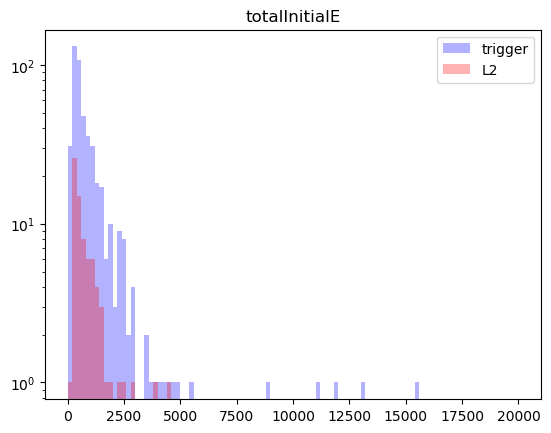

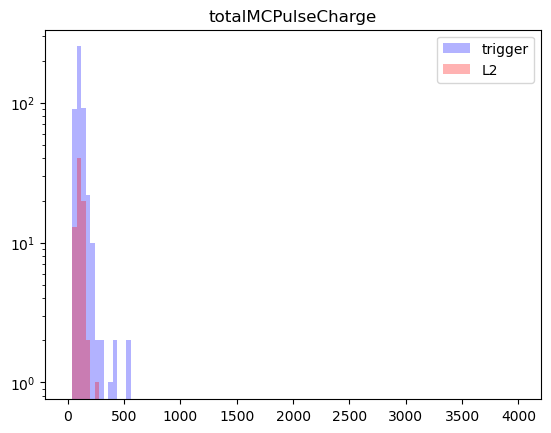

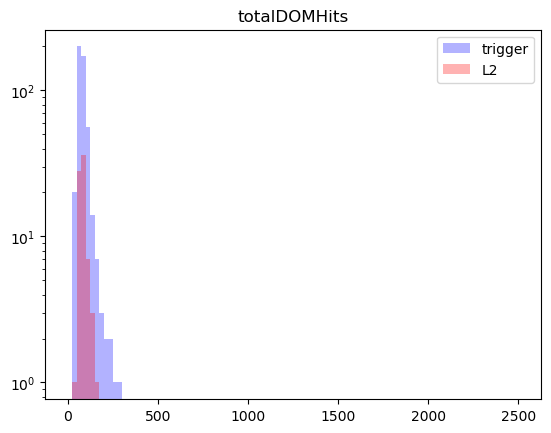

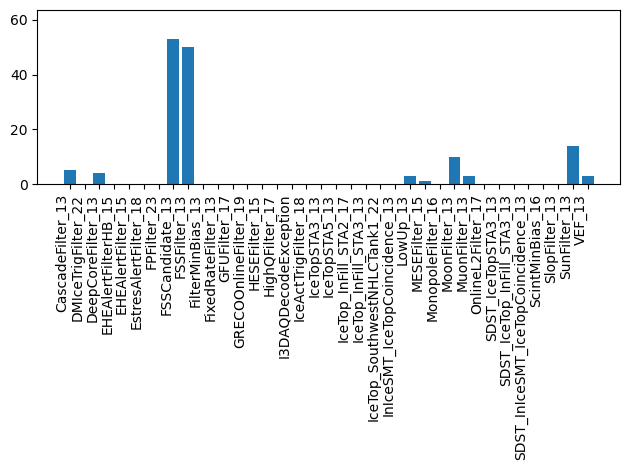

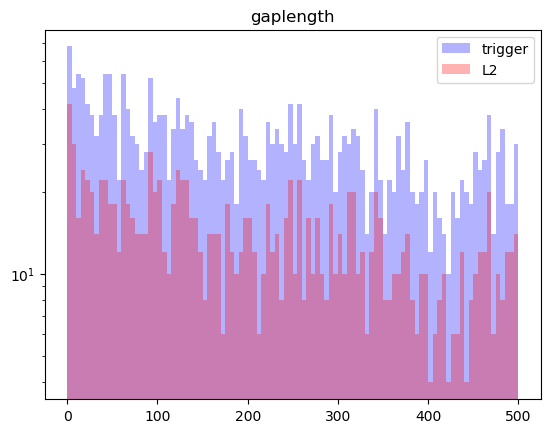

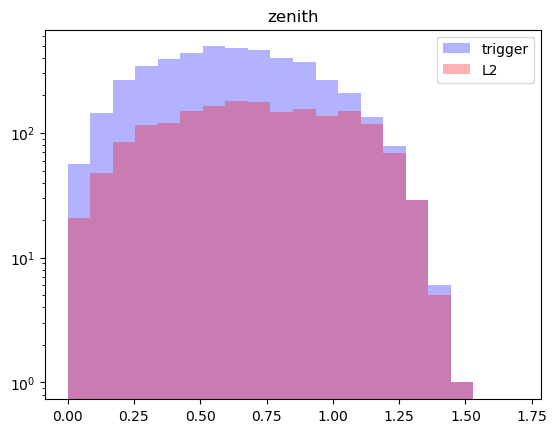

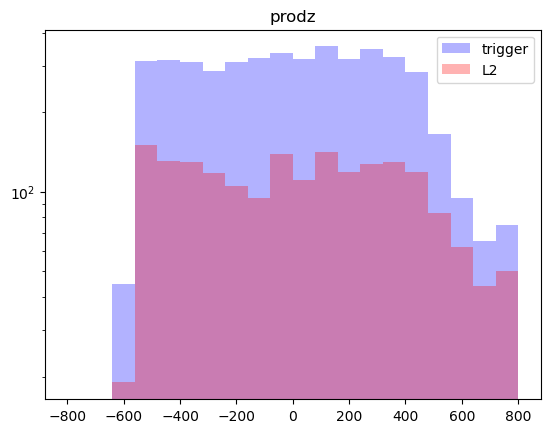

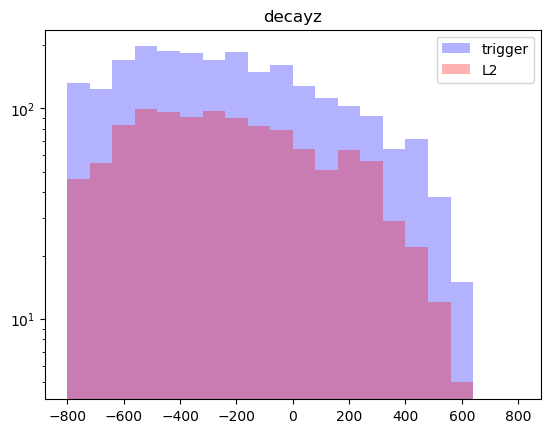

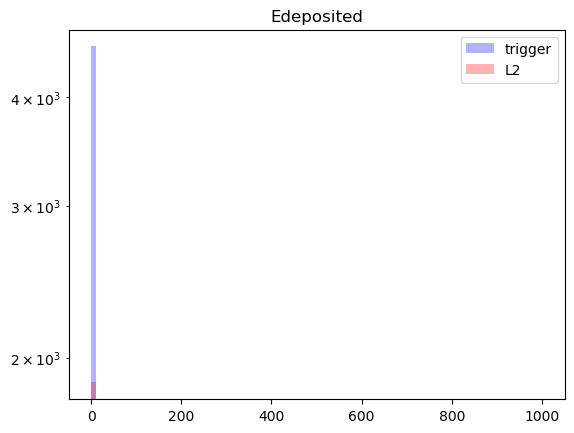

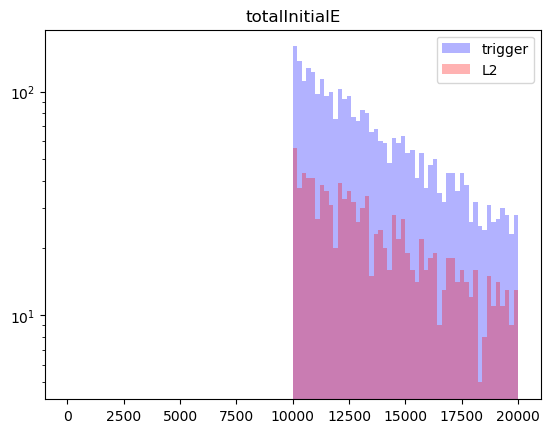

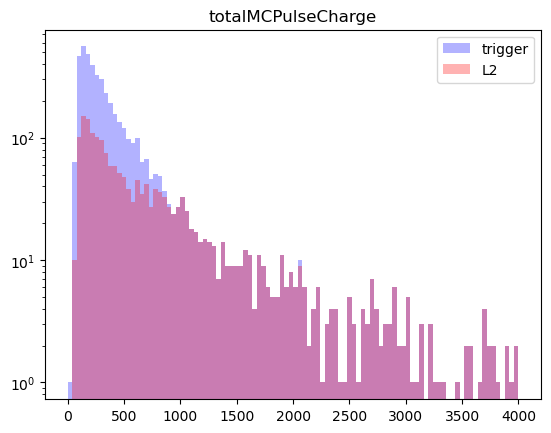

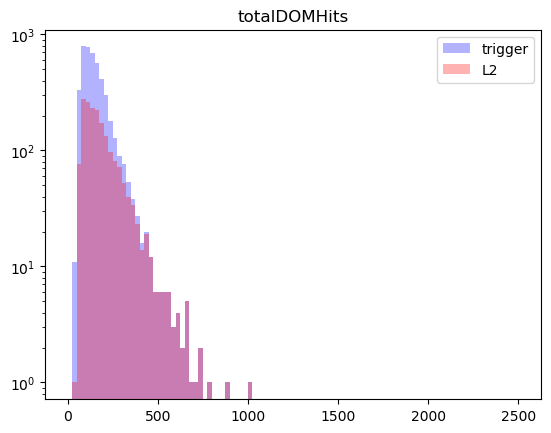

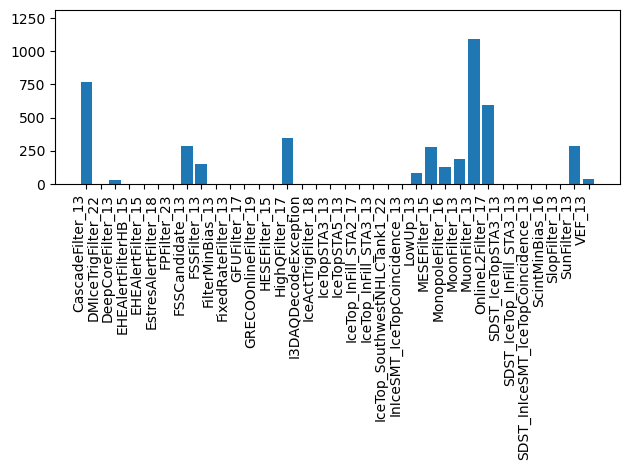

In [5]:
# dataset enum
for enum in range(1,6):
    # which dataset
    if enum == 1:
        datapath = "/data/user/axelpo/LLP-data/DarkLeptonicScalar.mass-130.eps-5e-6.nevents-5000_230919.196721189/"
        name     = "DLS"
        folder_path = "analyze_"+datapath[27:-1]+"/"
    elif enum == 2:
        datapath = "/data/user/axelpo/LLP-data/DarkLeptonicScalar.mass-130.eps-5e-6.nevents-5000_naturalrate_230919.196721196/"
        name     = "DLS_naturalrate"
        folder_path = "analyze_"+datapath[27:-1]+"/"
    elif enum == 3:
        datapath = "/data/user/axelpo/LLP-data/NO_LLP.DarkLeptonicScalar.mass-130.eps-5e-6.nevents-5000_230919.196721202/"
        name     = "NO_LLP"
        folder_path = "analyze_"+datapath[27:-1]+"/"
    elif enum == 4:
        datapath = "/data/user/axelpo/LLP-data/NO_LLP.DarkLeptonicScalar.mass-130.eps-5e-6.nevents-5000_naturalrate_230919.196721201/"
        name     = "NO_LLP_naturalrate"
        folder_path = "analyze_"+datapath[27:-1]+"/"
    elif enum == 5:
        datapath = "/data/user/axelpo/LLP-data/DarkLeptonicScalar.mass-130.eps-5e-6.nevents-5000_eitherdecayorprod_230921.196832696/"
        name     = "DLS_eitherdecayorprod"
        folder_path = "analyze_"+datapath[27:-1]+"/"
    
    with open(folder_path+"trigger_to_L2_analysis.json") as f:
        json_object = json.load(f)
    survivedL2 = json_object["runID_eventID_survivedL2"]
    
    tray = I3Tray()
    tray.Add("I3Reader", filenamelist= list(glob.glob(datapath+"LLPSim*/*.gz")))
    tray.Add(HistogramLLPs, folder_path = folder_path, survivedL2 = survivedL2, GCDFile = "/data/user/axelpo/LLP-at-IceCube/dark-leptonic-scalar-simulation/resources/GeoCalibDetectorStatus_2021.Run135903.T00S1.Pass2_V1b_Snow211115.i3.gz")
    tray.Execute()
    
    tray2 = I3Tray()
    tray2.Add("I3Reader", filename=datapath+"L2.i3.gz")
    tray2.Add(HistogramLevel2, folder_path = folder_path, GCDFile = "/data/user/axelpo/LLP-at-IceCube/dark-leptonic-scalar-simulation/resources/GeoCalibDetectorStatus_2021.Run135903.T00S1.Pass2_V1b_Snow211115.i3.gz")
    tray2.Execute()
